In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tabulate as tab
import cmath as math
import pandas as pd
from geneticalgorithm import geneticalgorithm as ga


# Parse data

In [21]:
## read the input data

vehicle_data_df = pd.read_excel("Case3_vehicle.xlsx", usecols=[1])
track_data_df = pd.read_excel("Case3_track.xlsx")
fuel_data_df = pd.read_excel("Case3_fuel.xlsx", usecols=[1])

## dataframe to array

vehicle_data = vehicle_data_df.to_numpy()
fuel_data = fuel_data_df.to_numpy()

## create parameters

### Vehicle

vehicle_weight = vehicle_data[0]  # kg
drag_coefficient = vehicle_data[1]
rolling_friction = vehicle_data[2]
frontal_area = vehicle_data[3]  # m^2

powertrain_power = vehicle_data[4]  # kW
powertrain_efficiency = 0.95

battery_capacity = vehicle_data[5]  # kWh
battery_power = vehicle_data[6]  # kW
battery_weight = vehicle_data[7]  # kg
battery_soc = 1

regenerative_breaking_power = vehicle_data[8]  # kW
regenerative_breaking_efficiency = vehicle_data[9]

cooling_system_power = vehicle_data[10] / 1000  # kW
lights_power = vehicle_data[11] / 1000  # kW
control_system_power = vehicle_data[12] / 1000  # kW

available_area_pv = vehicle_data[13]  # m2
pv_efficiency = vehicle_data[14]  # kw/m2
pv_power = available_area_pv * pv_efficiency * 600 / 1000  # kW
pv_weight = 3 * available_area_pv

total_weight = pv_weight + vehicle_weight + battery_weight  # kg

### environment

air_density = 1.225  # kg/m^3
gravity = 9.81  # m/s^2

### track

number_of_laps = 20  # can be optimized for any number of laps!
track_max_speed_kmph = track_data_df["Max Speed (km/h)"].values  # km/h
track_max_speed = track_max_speed_kmph * (1000 / 3600)  # m/s
track_length_km = track_data_df["Length (km)"].values  # km
track_length = track_length_km * 1000  # m
track_slope_deg = track_data_df["Slope (º)"].values  # º
track_slope = track_slope_deg * (math.pi / 180)  # radians

### fuel

Fuel_Efficiency = fuel_data[0]
co2_emissions = fuel_data[1]  # kgCO2/kWh
average_irradiance = fuel_data[2]  # w/m2

### check inputs

#### arrange data

vehicle_data_table_values = np.concatenate(
    (
        vehicle_weight,
        drag_coefficient,
        rolling_friction,
        frontal_area,
        powertrain_power,
        [powertrain_efficiency],
        battery_capacity,
        battery_power,
        battery_weight,
        [battery_soc],
        regenerative_breaking_power,
        regenerative_breaking_efficiency,
        cooling_system_power,
        lights_power,
        control_system_power,
        available_area_pv,
        pv_efficiency,
        pv_power,
        pv_weight,
        [air_density],
        [gravity],
        total_weight,
    )
)

vehicle_data_table_titles = np.concatenate(
    (
        ["vehicle weight"],
        ["drag coefficient"],
        ["rolling friction"],
        ["frontal area"],
        ["powertrain power"],
        ["powertrain efficiency"],
        ["battery capacity"],
        ["battery power"],
        ["battery weight"],
        ["battery soc"],
        ["regenerative breaking power"],
        ["regenerative breaking efficiency"],
        ["cooling system power"],
        ["lights power"],
        ["control system power"],
        ["available area pv"],
        ["pv efficiency"],
        ["pv power"],
        ["pv_weight"],
        ["air density"],
        ["gravity"],
        ["total weight"],
    )
)
vehicle_table = np.stack((vehicle_data_table_titles, vehicle_data_table_values), axis=1)

track_data_titles = np.concatenate(
    (
        ["speed limit (m/s)", "length (m)", "slope(degrees)"],
        np.concatenate(np.stack((track_max_speed, track_length, track_slope), axis=1)),
    )
)
track_table = np.reshape(track_data_titles, (-1, 3))

#### print tables

print("vehicle data")
print(tab.tabulate(vehicle_table))
print("track data")
print(tab.tabulate(track_table))
print("number of laps:", number_of_laps)

vehicle data
--------------------------------  -------
vehicle weight                    250
drag coefficient                    1.59
rolling friction                    0.01
frontal area                        1.5
powertrain power                  140
powertrain efficiency               0.95
battery capacity                    7.5
battery power                     140
battery weight                     50
battery soc                         1
regenerative breaking power       120
regenerative breaking efficiency    0.15
cooling system power                0.06
lights power                        0.05
control system power                0.5
available area pv                   1.5
pv efficiency                       0.22
pv power                            0.198
pv_weight                           4.5
air density                         1.225
gravity                             9.81
total weight                      304.5
--------------------------------  -------
track data
------------

# Some basic physics as a function

In [22]:
### initialize some variables

track_acceleration = np.array(np.zeros(42))

time_lap_minimum = 0

# Define objective function


def totaltime(track_speed):

### Globalize relevant variables

    global track_time, track_acceleration, power, energy, battery_final_capacity, total_energy

    track_time = track_length / track_speed

### Define acceleration

    i = 0
    for i in range(0, len(track_time)):
        if i == 0:
            track_acceleration[i] = (track_speed[i + 1] ** 2 + 0) / (
                2 * track_length[i]
            )  # m/s^2
        elif (i % 2) == 0:
            track_acceleration[i] = (
                track_speed[i + 1] ** 2 - track_speed[i - 1] ** 2
            ) / (2 * track_length[i])
        else:
            track_acceleration[i] = 0

### create acceleration sign array

    i = 0
    acceleration_sign = np.zeros(42)
    for i in range(0, len(track_time)):
        if track_acceleration[i] != 0:
            acceleration_sign[i] = np.sign(track_acceleration[i])
        if track_acceleration[i] == 0:
            acceleration_sign[i] = 1

# Calculate energy

## forces

    aerodynamic_force = (
        0.5
        * air_density
        * frontal_area
        * drag_coefficient
        * track_speed
        * track_speed
        * acceleration_sign
    )  # newtons
    slope_losses = (total_weight) * gravity * np.sin(track_slope)  # newtons
    acceleration_force = (total_weight) * (track_acceleration)  # newtons
    friction_losses = (
        (total_weight)
        * gravity
        * rolling_friction
        * np.cos(track_slope)
        * acceleration_sign
    )  # newtons
    total_force = (
        acceleration_force + aerodynamic_force + friction_losses + slope_losses
    )  # newtons
    for i in range(
        0, len(total_force)
    ):  # since regenerative breaking has an efficiency of 15%
        if total_force[i] < 0:
            total_force[i] = total_force[i] * regenerative_breaking_efficiency

## power and energy

    power = (
        -(total_force * track_speed) / 1000
        - control_system_power
        - lights_power
        - cooling_system_power
        + pv_power
    )  # kw (watt to kw /1000)
    energy = (power * (track_time / 3600)) / powertrain_efficiency  # kwh

## calculate total energy expended per lap

    total_energy = sum(energy)

## calculate final capacity after 20 laps

    battery_final_capacity = (
        battery_capacity + total_energy * number_of_laps
    )  # battery final capacity after 20 laps

# Calculate total time per lap

    total_time = sum(track_time)

    ## fitness algorithim (penalties)
    ### max power penalty
    if (power[i]) > min(powertrain_power, battery_power):
        total_time = total_time + 9999
    #         #### run out of battery capacity penalty (for 20 laps)
    if battery_final_capacity < 0:
        total_time = total_time + 9999

    total_time = total_time * number_of_laps  ##time for 20 laps!!

    return total_time

    ### Calculate speed


# Create the optimization model

 The best solution found:                                                                           
 [33.31325048 27.59054325 21.66655888 25.6003086  29.70372922 22.16967079
 19.33850378 17.68441156 16.52377621 23.51904032 30.53124033 20.79732342
 11.08969975 21.31342186 33.08972013 23.71738447 16.34931142 20.04098776
 24.01784627 27.62211514 30.47736877 24.0339356  18.94243473 24.94055231
 32.4537441  30.25533917 24.90655409 20.99459843 18.72948478 21.66829993
 28.70251601 24.41829854 18.42416575 22.02474757 24.95680291 26.61279346
 29.9776652  31.38597572 33.2175922  23.17425603 13.68640997 23.03540426]

 Objective function:
 719.5668868617087


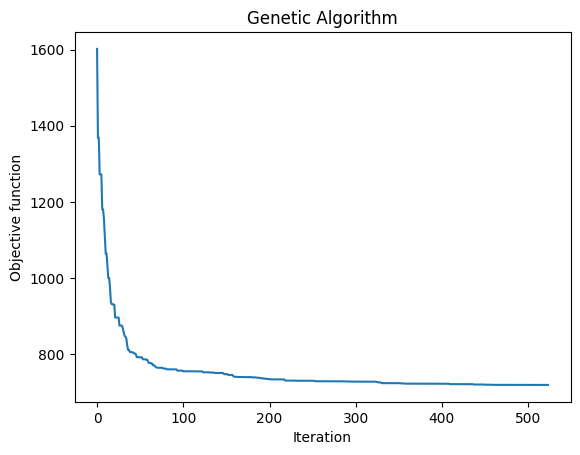

In [25]:


# Adjust GA parameters

algorithm_param = {
    "max_num_iteration": 600,
    "population_size": 100,
    "mutation_probability": 0.1,
    "elit_ratio": 0.01,
    "crossover_probability": 0.5,
    "parents_portion": 0.01,
    "crossover_type": "uniform",
    "max_iteration_without_improv": 50,
}

# set max speed boundary

varbound = np.stack((np.zeros(len(track_max_speed)), track_max_speed), axis=1)

# run genetic algorithm

model = ga(
    function=totaltime,
    dimension=len(track_length),
    variable_type="real",
    variable_boundaries=varbound,
    algorithm_parameters=algorithm_param,
)
model.run()

# Parse Results

model_values = model.output_dict.values()
model_values_list = list(model_values)

track_speed = model_values_list[0]
total_time = model_values_list[1]

# Check results



total time: 719.57 s
            00:11:59






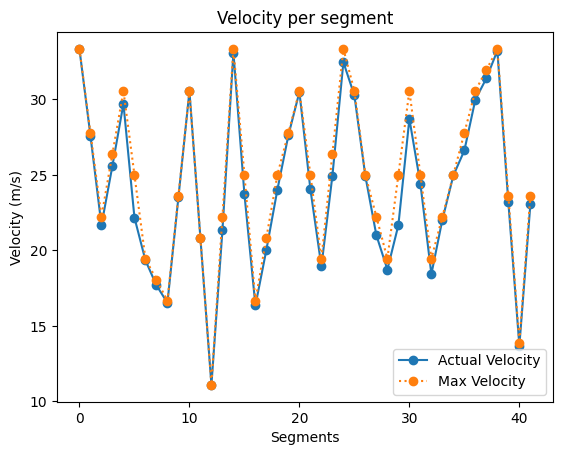

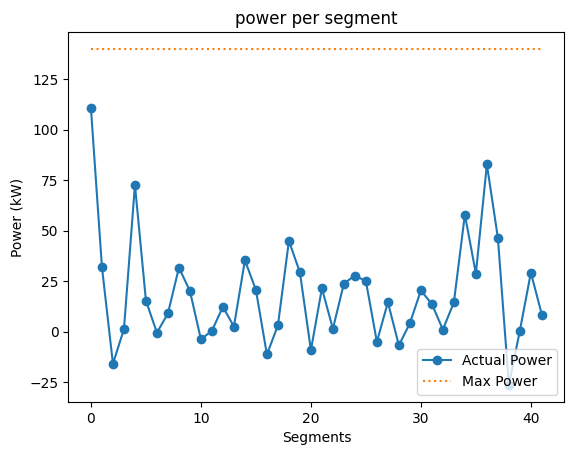

note: In the graph above, positive power denotes power wasted and negetive power denotes power generated.




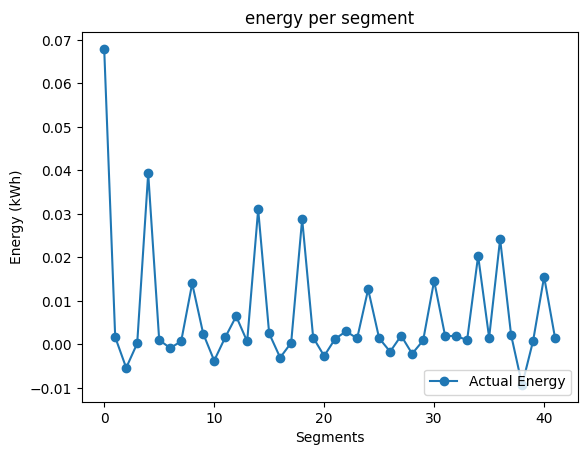

note: In the graph above, positive energy denotes power wasted and negetive power denotes energy generated.




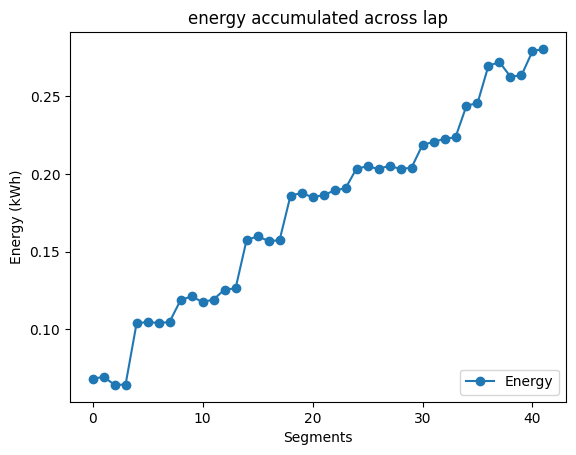

total energy spent per lap: 0.28060209949416165 kWh




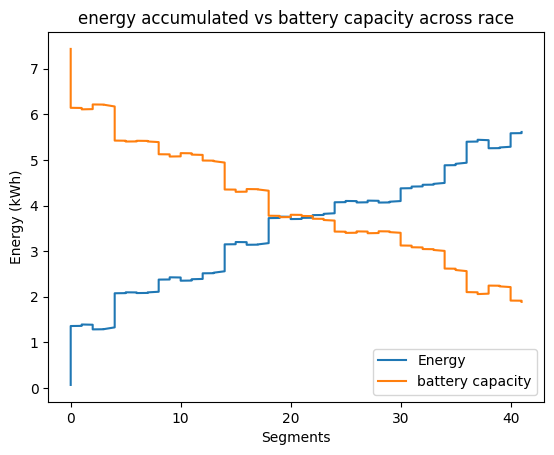

total energy spent across race: 5.612041989883244 kWh




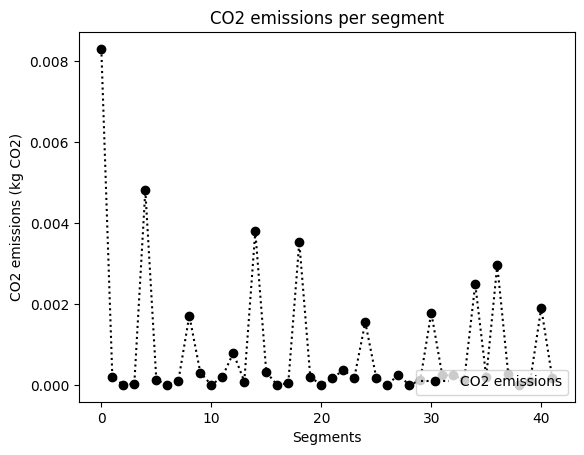

total CO2 emissions: 0.037791954435744624 kg CO2




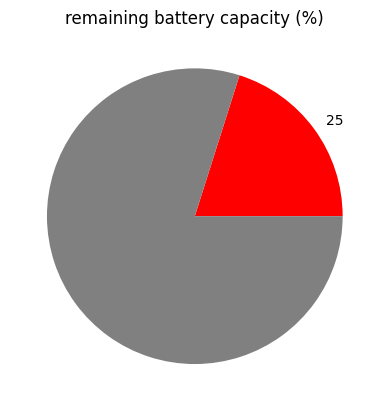

final battery capacity [1.88795801] kWh


In [26]:
# dashboard
print('\n')
print('total time:',round(total_time,2),'s')

from time import strftime
from time import gmtime
hours_mins_seconds=strftime("%H:%M:%S", gmtime(total_time))
print('           ',hours_mins_seconds)
print('\n')
print('\n')

segments=list(range(0,len(track_length)))
plt.plot(segments,track_speed,marker='o')
plt.plot(segments,track_max_speed,marker='o', linestyle='dotted')
plt.title("Velocity per segment")
plt.xlabel("Segments")
plt.ylabel("Velocity (m/s)")
plt.legend(["Actual Velocity", "Max Velocity"], loc ="lower right")
plt.show()
print('\n')

max_power=np.repeat(min(powertrain_power,battery_power),len(track_length))
plt.plot(segments,-power,marker='o')
plt.plot(segments,max_power,  linestyle='dotted')
plt.title("power per segment")
plt.xlabel("Segments")
plt.ylabel("Power (kW)")
plt.legend(["Actual Power", "Max Power"], loc ="lower right")
plt.show()
print('note: In the graph above, positive power denotes power wasted and negetive power denotes power generated.')
print('\n')

plt.plot(segments,-energy,marker='o')
plt.title("energy per segment")
plt.xlabel("Segments")
plt.ylabel("Energy (kWh)")
plt.legend(["Actual Energy"], loc ="lower right")
plt.show()
print('note: In the graph above, positive energy denotes power wasted and negetive power denotes energy generated.')
print('\n')

energy_accumulated_lap=np.zeros(42)
energy_accumulated_lap[0]=energy[0]
for i in range(0, len(energy)-1):
    energy_accumulated_lap[i+1]=energy_accumulated_lap[i]+energy[i+1]

plt.plot(segments,-energy_accumulated_lap,marker='o')
plt.title("energy accumulated across lap")
plt.xlabel("Segments")
plt.ylabel("Energy (kWh)")
plt.legend(["Energy"], loc ="lower right")
plt.show()
print('total energy spent per lap:',sum(-energy),'kWh')
print('\n')

energy_accumulated_race=np.zeros(840)
energy_accumulated_race[0]=energy[0]
energy_repeat=np.repeat(energy, 20)
for i in range(0, len(energy_repeat)-1):
    energy_accumulated_race[i+1]=energy_accumulated_race[i]+energy_repeat[i+1]
segments_race=np.repeat(segments,20)

battery_capacity_race=np.repeat(battery_capacity,840)
for i in range (0, len(battery_capacity_race)):
    battery_capacity_race[i]=battery_capacity_race[i]+energy_accumulated_race[i]




plt.plot(segments_race,-energy_accumulated_race)
plt.plot(segments_race,battery_capacity_race)
plt.title("energy accumulated vs battery capacity across race")
plt.xlabel("Segments")
plt.ylabel("Energy (kWh)")
plt.legend(["Energy",'battery capacity'], loc ="lower right")
plt.show()
print('total energy spent across race:',sum(-energy_repeat),'kWh')
print('\n')

#CO2 emissions:
co2=np.zeros(42)
for i in range(0 , len(energy)):
    if energy[i] < 0:
        co2[i]=co2_emissions*-energy[i]


plt.plot(segments,co2, 'o:k')
plt.title("CO2 emissions per segment")
plt.xlabel("Segments")
plt.ylabel("CO2 emissions (kg CO2)")
plt.legend(['CO2 emissions'], loc ='lower right')
plt.show()
print('total CO2 emissions:',sum(co2),'kg CO2')
print('\n')


pie = [float(battery_final_capacity),float(battery_capacity)]
ratio=round(float(battery_final_capacity/battery_capacity)*100)
plt.pie(pie,labels=[ratio,''],colors=['red','grey'])
plt.title('remaining battery capacity (%)')
plt.show() 
print('final battery capacity',battery_final_capacity,'kWh')